# 0. Import libraries

In [1]:
# !pip install kaggle
# !kaggle competitions download -c house-prices-advanced-regression-techniques

import zipfile

import pandas as pd
import numpy as np
from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme(style='darkgrid')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold

# 1. Load in data

In [2]:
with zipfile.ZipFile('house-prices-advanced-regression-techniques.zip') as zipf:
    zipf.printdir()
    zipf.extractall(path='data/')

File Name                                             Modified             Size
data_description.txt                           2019-12-15 21:33:36        13370
sample_submission.csv                          2019-12-15 21:33:36        31939
test.csv                                       2019-12-15 21:33:36       451405
train.csv                                      2019-12-15 21:33:36       460676


In [3]:
# read in training set and test set
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

# peek through the training and test data
pd.concat([df_train.head(), df_test.head()])

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,NaN
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,NaN
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,NaN
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,NaN
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,NaN,0,1,2010,WD,Normal,NaN


# 2. Inspect data

In [4]:
print(f"Shape of training set is {df_train.shape}")
print(f"Shape of test set is {df_test.shape}")

Shape of training set is (1460, 81)
Shape of test set is (1459, 80)


There are 1460 rows in the training set and 1459 rows in the test set.

The number of columns in both sets is the same. The one extra column in the training set is the target variable `SalePrice` that we are going to use to train our model.

The `Id` column is for identifying different houses. We suspect that it could be removed.

In [5]:
df_train['Id'].value_counts()

1       1
982     1
980     1
979     1
978     1
       ..
485     1
484     1
483     1
482     1
1460    1
Name: Id, Length: 1460, dtype: int64

Indeed it is. We can remove it from both training set and test set.

In [6]:
# define a function for easier removal of columns

def drop_col(cols):
    df_train.drop(cols, axis=1, inplace=True)
    df_test.drop(cols, axis=1, inplace=True)
    
# now remove Id
drop_col('Id')

## 2.1. Classify categorical features and numerical features

Categorical features and numerical features will be treated in different ways, hence we need to classify them.

In [7]:
df_test.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [8]:
num_cols, cat_cols = [], []

for col in df_test.columns:
    if df_test.dtypes[col] == object:
        cat_cols.append(col)
    else:
        num_cols.append(col)
        
print("Numerical columns include:", num_cols)
print("Categorical columns include:", cat_cols)

Numerical columns include: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
Categorical columns include: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu'

## 2.2. Explore target variable `SalePrice`

In [9]:
# summary statistics of the target variable
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

There seem to be some very large outliers that might affect the performance of the model.

<AxesSubplot:>

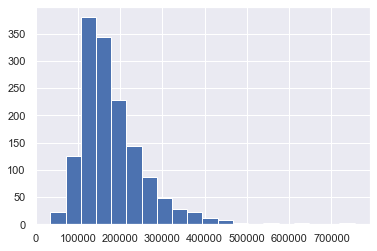

In [10]:
# distribution of the target variable
df_train['SalePrice'].hist(bins=20)

The distribution seems a bit skewed. Maybe a log- or sqrt- transformation is required.

In [11]:
# correlation with the feature variables
df_train.corr()['SalePrice'].reindex(df_train.corr()['SalePrice'].abs().sort_values(ascending=False).index)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
ScreenPorch      0.111447
PoolArea         0.092404
MSSubClass      -0.084284
OverallCond     -0.077856
MoSold           0.046432
3SsnPorch        0.044584
YrSold          -0.028923
LowQualFinSF    -0.025606
MiscVal         -0.021190
BsmtHalfBath    -0.016844
BsmtFinSF2      -0.011378
Name: SalePrice, dtype: float64

# 3. Missing values

In [12]:
# check missing values
print("Total number of missing values in the training set is:", df_train.isna().sum().sum())
print("Total number of missing values in the test set is:", df_test.isna().sum().sum())

Total number of missing values in the training set is: 6965
Total number of missing values in the test set is: 7000


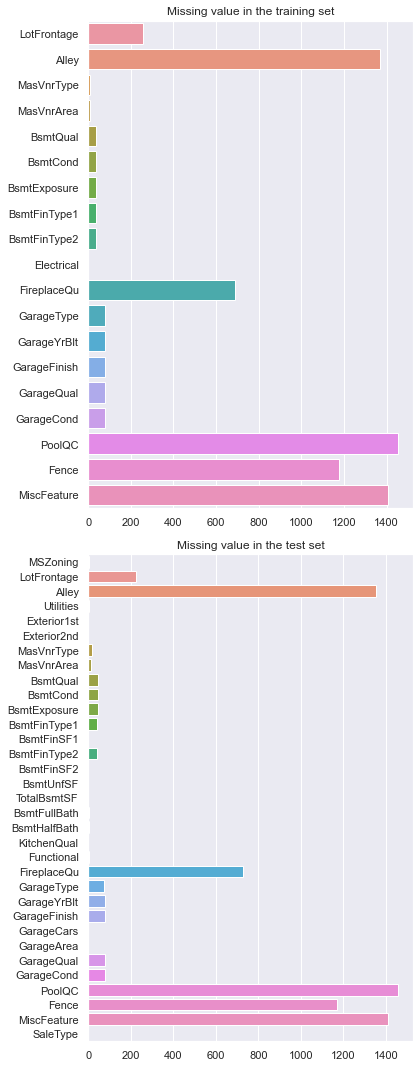

In [13]:
# the column-wise distribution of the missing values
plt.figure(figsize=(6,15))

na_col_train = df_train.columns[df_train.isna().sum() > 0].values
na_col_test = df_test.columns[df_test.isna().sum() > 0].values

plt.subplot(2,1,1)
sns.barplot(x=df_train.isna().sum()[na_col_train], y=na_col_train)
plt.title('Missing value in the training set')

plt.subplot(2,1,2)
sns.barplot(x=df_test.isna().sum()[na_col_test], y=na_col_test)
plt.title('Missing value in the test set')

plt.tight_layout()

## 3.1. Filling missing data according to descriptions

According to the data description file, 'NA' values in some features means 'No such thing'. For categorical features, what we can do is to add a new category (namely 'None') to represent those 'NA' value; for numerical features, replacing with zero is a good choice.

### Alley

For example, 'NA' value in `Alley` simply means no alley access of the property.

In [14]:
def fill_na_with(col, label):
    df_train[col] = df_train[col].fillna(label)
    df_test[col] = df_test[col].fillna(label)
    
fill_na_with('Alley', 'None')

### Mason veneer

In [15]:
fill_na_with('MasVnrType', 'None')

Mason veneer has two related features - type and area. If a property has no mason veneer (i.e. None type), we would also expect a zero area.

In [16]:
MasVnr_features = ['MasVnrType', 'MasVnrArea']
print(df_train.loc[df_train['MasVnrType'] == 'None', MasVnr_features].value_counts())
print(df_test.loc[df_test['MasVnrType'] == 'None', MasVnr_features].value_counts())

MasVnrType  MasVnrArea
None        0.0           859
            1.0             2
            288.0           1
            312.0           1
            344.0           1
dtype: int64
MasVnrType  MasVnrArea
None        0.0           876
            1.0             1
            198.0           1
            285.0           1
dtype: int64


Well, this is problematic, because a property with 'None' type mason veneer cannot possibly have an area. We can only assume that something went wrong during the data collection process.

However, at this stage, we must decide on how to deal with it. Since there are only few abnormal data points in the `MasVnrArea` feature, we will choose to stick with the type and set all mason veneer area variable to zero for 'None' type rows.

In [17]:
# set area to zero
df_train.loc[df_train['MasVnrType'] == 'None', 'MasVnrArea'] = 0
df_test.loc[df_test['MasVnrType'] == 'None', 'MasVnrArea'] = 0

### Basement

There are many basement-related features. In order to be consistent, a property with NA in any basement-related feature need to be labelled NA and zero in all basement-related features. We will need to make sure of that before filling missing values.

In [18]:
# define a function for finding the problematic indexes of rows
def find_pi(cat, num):
    # create hashmaps for storing na values count
    hashmap_train, hashmap_test = defaultdict(int), defaultdict(int)

    # iterate through all related categorical features
    for col in cat:
        # temporarily store index of rows containing na value for a given feature
        index_train = df_train[df_train[col].isna()].index.values
        index_test = df_test[df_test[col].isna()].index.values
        
        # build the counter
        for i in index_train:
            hashmap_train[i] += 1
        for i in index_test:
            hashmap_test[i] += 1
    
    # if the count of na values for a given index is equal to the length of the cat list, 
    # it means that all related categorical features are consistent. 
    # Else, the row is problematic.

    # create list to store the problematic row indexes.        
    pi_train, pi_test = [], []

    # iterate through the hashmap
    for k, v in hashmap_train.items():
        # if the count is smaller than the length, add the index of the row to the list
        if v < len(cat):
            pi_train.append(k)
        # also count in the rows where the categorical features are consistent 
        # but the numerical features are problematic
        else:
            # if the sum of the numerical data is not zero
            if df_train.loc[k, num].sum():
                pi_train.append(k)

    for k, v in hashmap_test.items():
        if v < len(cat):
            pi_test.append(k)
        else:
            if df_test.loc[k, num].sum():
                pi_test.append(k)
    
    return pi_train, pi_test

In [19]:
# list all basement-related feautures
Bsmt_cat = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
Bsmt_num = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']

pi_Bsmt_train, pi_Bsmt_test = find_pi(Bsmt_cat, Bsmt_num)

In [20]:
df_train.loc[pi_Bsmt_train, Bsmt_cat+Bsmt_num]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
948,Gd,TA,NaN,Unf,Unf,0,0,936,936
332,Gd,TA,No,GLQ,NaN,1124,479,1603,3206


In [21]:
df_test.loc[pi_Bsmt_test, Bsmt_cat+Bsmt_num]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
757,NaN,Fa,No,Unf,Unf,0.0,0.0,173.0,173.0
758,NaN,TA,No,Unf,Unf,0.0,0.0,356.0,356.0
580,Gd,NaN,Mn,GLQ,Rec,1044.0,382.0,0.0,1426.0
725,TA,NaN,No,BLQ,Unf,1033.0,0.0,94.0,1127.0
1064,TA,NaN,Av,ALQ,Unf,755.0,0.0,240.0,995.0
27,Gd,TA,NaN,Unf,Unf,0.0,0.0,1595.0,1595.0
888,Gd,TA,NaN,Unf,Unf,0.0,0.0,725.0,725.0


These missing values should be actually 'missing' due to some error in data collection process. We can fill them with the most common label in each columns.

In [22]:
# define a function
def fill_with_mode(df, index, col):
    df.loc[index, col] = df[col].mode()[0]

# BsmtExposure
fill_with_mode(df_train, 948, 'BsmtExposure')

# BsmtFinType2
fill_with_mode(df_train, 332, 'BsmtFinType2')

# BsmtQual
fill_with_mode(df_test, [757, 758], 'BsmtQual')

# BsmtCond
fill_with_mode(df_test, [580, 725, 1064], 'BsmtCond')

# BsmtExposure
fill_with_mode(df_test, [27, 888], 'BsmtExposure')

Then fill the rest of the NA value with 'None' label.

In [23]:
fill_na_with(Bsmt_cat, 'None')

Recall that there are some NA value in the basement-related numerical features in the test set.

In [24]:
df_test.loc[df_test[Bsmt_num].isna().sum(axis=1) > 0, Bsmt_cat+Bsmt_num]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
660,None,None,None,None,None,NaN,NaN,NaN,NaN


Seems that it is a property with no basement. We should fill the NA value with zero.

In [25]:
fill_na_with(Bsmt_num, 0)

### Fireplace

Fireplace has two related features - number of fireplaces and quality. Similarly, if a property has no fireplace (i.e. 0 in number), we would also expect a NA in the quality, and vice versa.

In [26]:
# check FireplaceQu for all properties with no fireplace
print(len(df_train.loc[df_train['Fireplaces'] == 0, 'FireplaceQu'].value_counts()))
print(len(df_test.loc[df_test['Fireplaces'] == 0, 'FireplaceQu'].value_counts()))

# check the opposite
print(len(df_train.loc[df_train['FireplaceQu'].isna(), 'Fireplaces'].value_counts()))
print(len(df_test.loc[df_test['FireplaceQu'].isna(), 'Fireplaces'].value_counts()))

0
0
1
1


The result indicates that there is no conflict between the two vairables. Therefore, all we need to do is to fill NA values with 'None' label.

In [27]:
fill_na_with('FireplaceQu', 'None')

### Garage

Garage is another one that has many features.

In [28]:
# list the garage-related features
Garage_cat = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
Garage_num = ['GarageYrBlt', 'GarageCars', 'GarageArea']

# check the consistency
print(df_train[Garage_cat+Garage_num].isna().sum())
print(df_test[Garage_cat+Garage_num].isna().sum())

GarageType      81
GarageFinish    81
GarageQual      81
GarageCond      81
GarageYrBlt     81
GarageCars       0
GarageArea       0
dtype: int64
GarageType      76
GarageFinish    78
GarageQual      78
GarageCond      78
GarageYrBlt     78
GarageCars       1
GarageArea       1
dtype: int64


There are some inconsistency in the number of NA values. We need to take a closer look.

In [29]:
# use the similar approach as we did for basement-related features
pi_Garage_train, pi_Garage_test = find_pi(Garage_cat, Garage_num)

In [30]:
df_train.loc[pi_Garage_train, Garage_cat+Garage_num]

,GarageType,GarageFinish,GarageQual,GarageCond,GarageYrBlt,GarageCars,GarageArea


In [31]:
df_test.loc[pi_Garage_test, Garage_cat+Garage_num]

,GarageType,GarageFinish,GarageQual,GarageCond,GarageYrBlt,GarageCars,GarageArea
666,Detchd,NaN,NaN,NaN,NaN,1.0,360.0
1116,Detchd,NaN,NaN,NaN,NaN,NaN,NaN


The two problematic rows are both in test set. It is more likely that the missing values are actually 'missing' rather than due to no garage. Hence we will fill the NA categorical value with the most common label and fill the NA numerical value with the median.

In [32]:
# fill cat features with mode
for col in Garage_cat[1:]:
    fill_with_mode(df_test, [666, 1116], col)

# fill num features with median
def fill_with_median(df, index, col):
    df.loc[index, col] = df[col].median()

fill_with_median(df_test, [666, 1116], 'GarageYrBlt')

fill_with_median(df_test, 1116, 'GarageCars')

fill_with_median(df_test, 1116, 'GarageArea')

At last, fill the rest of the NA cat values with 'None' and NA num values with zero.

In [33]:
fill_na_with(Garage_cat, 'None')
fill_na_with(Garage_num, 0)

### Pool

Pool has two features - area and quality.

In [34]:
print(len(df_train.loc[df_train['PoolQC'].isna(), 'PoolArea'].value_counts()))
print(len(df_test.loc[df_test['PoolQC'].isna(), 'PoolArea'].value_counts()))

print(len(df_train.loc[df_train['PoolArea'] == 0, 'PoolQC'].value_counts()))
print(len(df_test.loc[df_test['PoolArea'] == 0, 'PoolQC'].value_counts()))

1
4
0
0


There seems to be some problem in the test set.

In [35]:
df_test.loc[df_test['PoolQC'].isna(), 'PoolArea'].value_counts()

0      1453
368       1
444       1
561       1
Name: PoolArea, dtype: int64

In [36]:
df_test.groupby('PoolQC')['PoolArea'].describe()

,count,mean,std,min,25%,50%,75%,max
PoolQC,,,,,,,,
Ex,2.0,186.0,59.39697,144.0,165.0,186.0,207.0,228.0
Gd,1.0,800.0,NaN,800.0,800.0,800.0,800.0,800.0


We can either estimate all their pool quality according to their area, or set all their pool area to zero.

Since we do not have enough sample size to estimate, we will go with the latter approach.

In [37]:
df_test.loc[df_test['PoolQC'].isna(), 'PoolArea'] = 0

And then set all NA value to 'None'.

In [38]:
fill_na_with('PoolQC', 'None')

### Fence and MiscFeature

The rest two features can be easily filled with 'None'.

In [39]:
fill_na_with(['Fence', 'MiscFeature'], 'None')

## 3.2. Filling the rest of the missing data

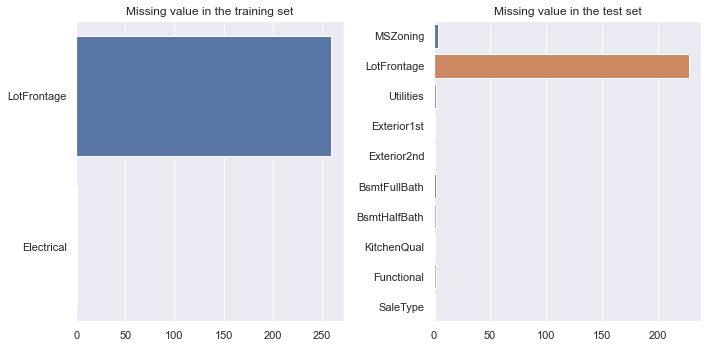

In [40]:
plt.figure(figsize=(10,5))

na_col_train = df_train.columns[df_train.isna().sum() > 0].values
na_col_test = df_test.columns[df_test.isna().sum() > 0].values

plt.subplot(1,2,1)
sns.barplot(x=df_train.isna().sum()[na_col_train], y=na_col_train)
plt.title('Missing value in the training set')

plt.subplot(1,2,2)
sns.barplot(x=df_test.isna().sum()[na_col_test], y=na_col_test)
plt.title('Missing value in the test set')

plt.tight_layout()

For `LotFrontage`, we can assume that the missing data is due to no frontage. Hence we will fill the NA values with 0 here.

In [41]:
fill_na_with('LotFrontage', 0)

For the NA values in `BsmtFullBath` and `BsmtHalfBath`, by taking a closer look at them, we can find that these properties do not have basement. So we can safely replace NA values with 0.

In [42]:
# inspect the categorical basement-related features of rows with missing BsmtFullBath and ~HalfBath
pd.concat([df_test.loc[df_test['BsmtHalfBath'].isna(), Bsmt_cat],
           df_test.loc[df_test['BsmtHalfBath'].isna(), Bsmt_cat]])

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2
660,None,None,None,None,None
728,None,None,None,None,None
660,None,None,None,None,None
728,None,None,None,None,None


In [43]:
# replace with 0
fill_na_with(['BsmtFullBath', 'BsmtHalfBath'], 0)

The rest of the missing data should be filled with most common labels.

In [44]:
# electrical
df_train['Electrical'] = df_train['Electrical'].fillna(df_train['Electrical'].mode()[0])

# test set
for col in na_col_test:
    df_test[col] = df_test[col].fillna(df_test[col].mode()[0])

In [45]:
# recheck the number of missing value in both data sets
print(df_train.isna().sum().sum(), df_test.isna().sum().sum())

0 0


# 4. Preprocessing

In this section, we are going to get the data prepared for our model.

There are several things we need to do:
- transform the target variable to make it more normally-distributed
- explore the features
- encode the categorical features
- scale the numerical features

In [46]:
# First prepare with feature and target data
X = df_train.drop('SalePrice', axis=1).copy()
y = df_train['SalePrice'].copy()

X_test = df_test.copy()

## 4.1. Transform target variable

<AxesSubplot:>

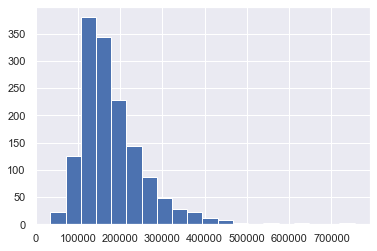

In [47]:
# distribution of the target variable
y.hist(bins=20)

<AxesSubplot:>

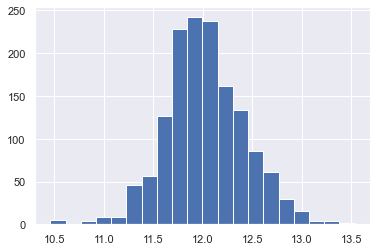

In [48]:
# log-transformation
np.log(y).hist(bins=20)

In [49]:
log_y = np.log(y)

## 4.2. Feature engineering

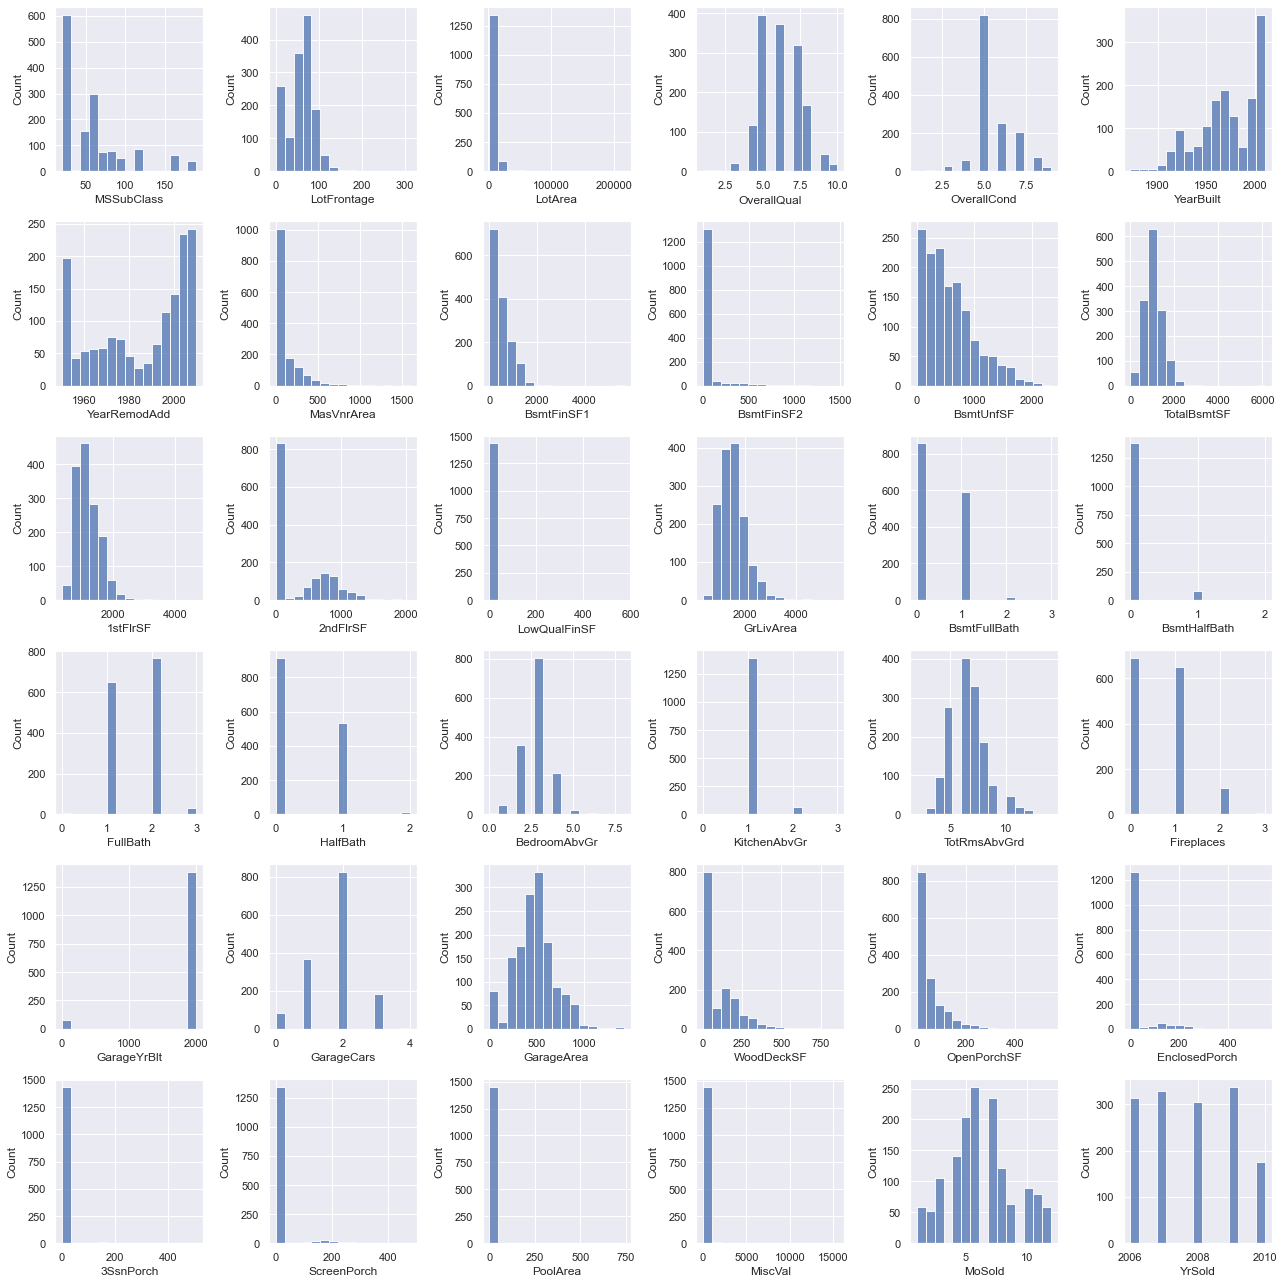

In [50]:
# plot distribution of all the numerical features
plt.figure(figsize=(18, 18))

for i, col in enumerate(num_cols):
    plt.subplot(6, 6, i+1)
    sns.histplot(data=X, x=col, bins=15)

plt.tight_layout()
plt.show()

Some findings:
1. Some features should actually be classified as categorical data. The numerical data only act as a label. (e.g. `GarageYrBlt`, `OverallQual`, etc.)
2. Many features need to be transformed to better fit a regression model.
3. Some variables are largely dominated by zero values. These variables can be used to create new binary categorical features.

In [51]:
# classify some numerical features to categorical features
num_to_cat = ['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 
              'GarageYrBlt', 'MoSold', 'YrSold']

for col in num_to_cat:
    num_cols.remove(col)
    cat_cols.append(col)
    
# we also need to set their data types to str
X[num_to_cat] = X[num_to_cat].astype(str)
X_test[num_to_cat] = X_test[num_to_cat].astype(str)

In [52]:
# list features with questionable distribution
non_normal = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 
              '1stFlrSF', 'GrLivArea', 'WoodDeckSF', 'OpenPorchSF']

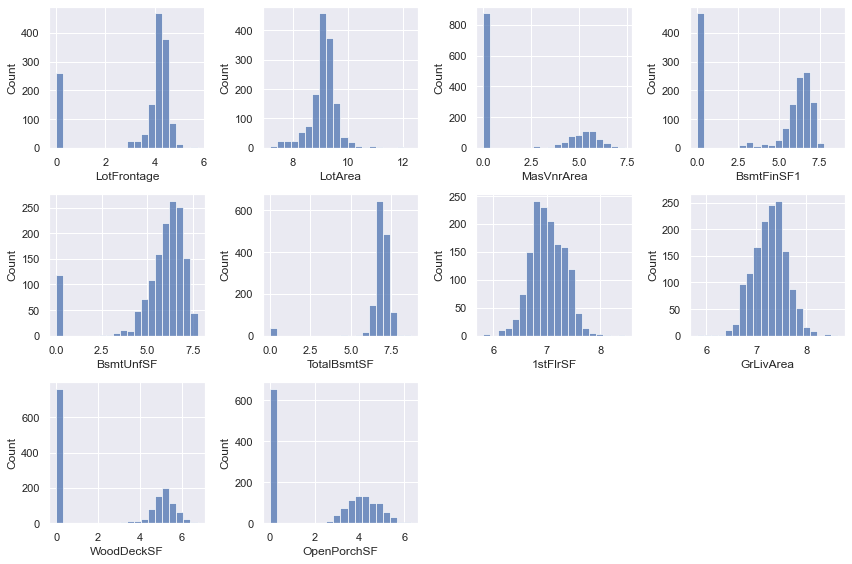

In [53]:
plt.figure(figsize=(12, 8))

for i, col in enumerate(non_normal):
    plt.subplot(3, 4, i+1)
    if X[col].min():
        sns.histplot(x=np.log(X[col]), bins=20)
    else:
        sns.histplot(x=np.log(X[col]+1), bins=20)

plt.tight_layout()
plt.show()

They look more normally distributed after the transformation. Hence we will perform log-transformation to them, as well as to the test set data.

In [54]:
for col in non_normal:
    # if there is no zero value
    if X[col].min() and X_test[col].min():
        X[col] = np.log(X[col])
        X_test[col] = np.log(X_test[col])
    # if there is any zero value, we must add 1 before performing log transformation
    # bacause log(0) is invalid
    else:
        X[col] = np.log(X[col] + 1)
        X_test[col] = np.log(X_test[col] + 1)

In [55]:
# list features that have many zero values (over 1000)
zeros_features = ['BsmtFinSF2', 'LowQualFinSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
                  'PoolArea', 'MiscVal']

If we were to compute `BsmtFinSF2` to a binary categorical feature (i.e. has type 2 or not), there is already a feature `BsmtFinType2` that contains this information. Hence we can delete it from the data set.

In [56]:
# delete BsmtFinSF2
X.drop('BsmtFinSF2', axis=1, inplace=True)
X_test.drop('BsmtFinSF2', axis=1, inplace=True)

# also delete it from column name list
num_cols.remove('BsmtFinSF2')
zeros_features.remove('BsmtFinSF2')

The same is true for `PoolArea` and `MiscVal`

In [57]:
X.drop(['PoolArea', 'MiscVal'], axis=1, inplace=True)
X_test.drop(['PoolArea', 'MiscVal'], axis=1, inplace=True)

num_cols.remove('PoolArea')
zeros_features.remove('PoolArea')
num_cols.remove('MiscVal')
zeros_features.remove('MiscVal')

For the rest 4 features, we can compute a binary categorical feature to replace each of them.

In [58]:
for col in zeros_features:
    X[col] = df_train[col] > 0
    X_test[col] = df_test[col] > 0
    
    # also move them to cat_cols
    num_cols.remove(col)
    cat_cols.append(col)

## 4.3. Encoding categorical features

Regression models can only deal with numerical data, hence we need to convert all categorical features to some sort of numerical features.

Here we will use `pandas.get_dummies` to do so. It will convert a categorical feature into several feaures with only 0 and 1. For example, if a feature `cat` has three categories 'a', 'b' and 'c', this method will convert it into three features `cat_a`, `cat_b` and `car_c`. Category 'a' will be represented as 1 in `cat_a`, and 0 in `cat_b` and `cat_c`.

In [59]:
# perform get_dummies on the combination of training and test sets to avoid inconsistency of encoding
# e.g. a category shows up with training set but not in test set.

all_data = pd.concat([X, X_test]).copy()
print(all_data.shape)

all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2919, 76)
(2919, 626)


In [60]:
# inspect the data type
all_data.dtypes.value_counts()

uint8      601
float64     14
int64        7
bool         4
dtype: int64

In [61]:
# we should convert the boolean type (T or F) to integer type (1 or 0)
all_data[all_data.dtypes[all_data.dtypes == bool].index.values] = \
    all_data[all_data.dtypes[all_data.dtypes == bool].index.values].astype(int)

In [62]:
# split the encoded data set back into training and test sets
X = all_data[:len(X)]
X_test = all_data[len(X):]
print(X.shape, X_test.shape)

(1460, 626) (1459, 626)


## 4.4. Scale numerical features

In [63]:
# initialise scaler
scaler = StandardScaler()

scale_X, scale_X_test = X.copy(), X_test.copy()

for col in num_cols:
    scale_X[col] = scaler.fit_transform(scale_X[col].values.reshape(-1,1))
    scale_X_test[col] = scaler.fit_transform(scale_X_test[col].values.reshape(-1,1))

# 5. Model selection